In [1]:
# Checklist:
# AWS emr-5.29.0
# MASTER r5d.8xlarge 1x, no EBS
# CORE r5d.8xlarge 4x, no EBS
# Custom bootstrap action: s3://ydatazian/bootstrap.sh
# Allow ssh in master node security group

In [118]:
import tqdm.notebook as tqdm
import numpy as np
import scipy
import sklearn
import matplotlib.pyplot as plt
from pyspark.sql.functions import *

# SparkSession

https://spark.apache.org/docs/2.4.4/api/python/pyspark.html

https://spark.apache.org/docs/2.4.4/api/python/pyspark.sql.html

In [19]:
import findspark
findspark.init()


import spark_utils
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
sc = SparkContext("yarn", "My App", conf=spark_utils.get_spark_conf())
se = SparkSession(sc)
spark_utils.print_ui_links()

NameNode: http://ec2-3-210-197-146.compute-1.amazonaws.com:50070
YARN: http://ec2-3-210-197-146.compute-1.amazonaws.com:8088
Spark UI: http://ec2-3-210-197-146.compute-1.amazonaws.com:20888/proxy/application_1589978798218_0002


# Ephemeral local HDFS

In [20]:
! hdfs dfs -df -h


Filesystem                                 Size     Used  Available  Use%
hdfs://ip-172-31-5-199.ec2.internal:8020  1.1 T  455.3 M      1.1 T    0%


In [21]:
! hdfs dfs -ls /

Found 3 items
drwxrwxrwt   - hdfs hadoop          0 2020-05-20 12:46 /tmp
drwxr-xr-x   - hdfs hadoop          0 2020-05-20 12:46 /user
drwxr-xr-x   - hdfs hadoop          0 2020-05-20 12:46 /var


# Persistent S3

https://www.kaggle.com/c/outbrain-click-prediction/data

In [22]:
! aws s3 ls s3://ydatazian

2020-05-19 13:37:37       1854 bootstrap.sh
2020-05-07 21:18:30  176843889 clicks_test.parquet
2020-05-07 21:18:30  495815517 clicks_train.parquet
2020-05-07 21:18:30   34267065 documents_categories.parquet
2020-05-07 21:18:30  206455957 documents_entities.parquet
2020-05-07 21:18:30   23859965 documents_meta.parquet
2020-05-07 21:18:31  187410196 documents_topics.parquet
2020-05-07 21:18:32  734643471 events.parquet
2020-05-07 21:18:35 50764611872 page_views.parquet
2020-05-07 21:18:35  248421413 page_views_sample.parquet
2020-05-07 21:18:36    5116927 promoted_content.parquet
2020-05-07 21:18:36  273136709 sample_submission.csv


# Read directly from S3

In [23]:
df = se.read.parquet("s3://ydatazian/page_views.parquet")
df.show(5)

+--------------+-----------+---------+--------+------------+--------------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|
+--------------+-----------+---------+--------+------------+--------------+
|1fd5f051fba643|        120| 31905835|       1|          RS|             2|
|8557aa9004be3b|        120| 32053104|       1|       VN>44|             2|
|c351b277a358f0|        120| 54013023|       1|       KR>12|             1|
|8205775c5387f9|        120| 44196592|       1|       IN>16|             2|
|9cb0ccd8458371|        120| 65817371|       1|   US>CA>807|             2|
+--------------+-----------+---------+--------+------------+--------------+
only showing top 5 rows



# Register all tables for sql queries

In [24]:
from IPython.display import display
tables = ["clicks_test", "clicks_train", 
          "documents_categories", "documents_entities", "documents_meta", "documents_topics", 
          "events", "page_views", "page_views_sample", "promoted_content"]
for name in tqdm.tqdm(tables):
    df = se.read.parquet("s3://ydatazian/{}.parquet".format(name))
    df.registerTempTable(name)
    print(name)
    display(df.limit(3).toPandas())

clicks_test


,display_id,ad_id
0,16874594,66758
1,16874594,150083
2,16874594,162754


clicks_train


,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1


documents_categories


,document_id,category_id,confidence_level
0,1595802,1611,0.92
1,1595802,1610,0.07
2,1524246,1807,0.92


documents_entities


,document_id,entity_id,confidence_level
0,1524246,f9eec25663db4cd83183f5c805186f16,0.672865314504701
1,1524246,55ebcfbdaff1d6f60b3907151f38527a,0.399113728441297
2,1524246,839907a972930b17b125eb0247898412,0.392095749652966


documents_meta


,document_id,source_id,publisher_id,publish_time
0,1595802,1,603,2016-06-05 00:00:00
1,1524246,1,603,2016-05-26 11:00:00
2,1617787,1,603,2016-05-27 00:00:00


documents_topics


,document_id,topic_id,confidence_level
0,1595802,140,0.0731131601068925
1,1595802,16,0.0594164867373976
2,1595802,143,0.0454207537554526


events


,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505


page_views


,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1


page_views_sample


,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1


promoted_content


,ad_id,document_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7


# Simple SQL query

In [49]:
%%time
df = se.sql(
"""
select 
    uuid, 
    count(1) as cnt
from page_views_sample
group by uuid
""")
df.write.parquet("/count_per_user.parquet", mode='overwrite')

CPU times: user 1.34 ms, sys: 296 µs, total: 1.64 ms
Wall time: 6.61 s


In [26]:
%%time
se.read.parquet("/count_per_user.parquet").show(5)

+--------------+---+
|          uuid|cnt|
+--------------+---+
|69a0927195c09e|  1|
|916d104e0c236d|  1|
|63dba7c280a635|  8|
|4d734fe22d203e|  8|
|b6b3ce2563ef84|  8|
+--------------+---+
only showing top 5 rows

CPU times: user 2.46 ms, sys: 0 ns, total: 2.46 ms
Wall time: 552 ms


In [27]:
! hdfs dfs -ls /

Found 4 items
drwxr-xr-x   - hadoop hadoop          0 2020-05-20 13:17 /count_per_user.parquet
drwxrwxrwt   - hdfs   hadoop          0 2020-05-20 12:46 /tmp
drwxr-xr-x   - hdfs   hadoop          0 2020-05-20 12:46 /user
drwxr-xr-x   - hdfs   hadoop          0 2020-05-20 12:46 /var


# The same in Python (10x slower)

In [32]:
df = se.table("page_views")
print(df)

DataFrame[uuid: string, document_id: string, timestamp: string, platform: string, geo_location: string, traffic_source: string]


In [35]:
rdd = df.rdd
print(rdd)
print(rdd.take(1))  # sent to driver (our Jupyter kernel)
print(rdd.take(1)[0].uuid)  # Python object

MapPartitionsRDD[81] at javaToPython at NativeMethodAccessorImpl.java:0
[Row(uuid='1fd5f051fba643', document_id='120', timestamp='31905835', platform='1', geo_location='RS', traffic_source='2')]
1fd5f051fba643


In [37]:
%%time
! hdfs dfs -rm -r /count_per_user.pickle
se.table("page_views_sample").rdd\
    .map(lambda x: (x.uuid, 1))\
    .reduceByKey(lambda x, y: x + y)\
    .saveAsPickleFile("/count_per_user.pickle")

Deleted /count_per_user.pickle
CPU times: user 40.2 ms, sys: 20.4 ms, total: 60.6 ms
Wall time: 53.1 s


In [38]:
%%time
sc.pickleFile("/count_per_user.pickle").take(5)

CPU times: user 5.29 ms, sys: 697 µs, total: 5.99 ms
Wall time: 288 ms


[('2d69a890cd1ba0', 1),
 ('b140951c4d9d8c', 1),
 ('384b0d7755f580', 1),
 ('a1e85bea40b482', 1),
 ('e34c8f23ee7c20', 1)]

In [39]:
# and we can convert it back to Spark DataFrame
from pyspark.sql import Row
rdd_of_rows = sc.pickleFile("/count_per_user.pickle")\
    .map(lambda x: Row(uuid=x[0], cnt=x[1]))
df = se.createDataFrame(rdd_of_rows)
df.write.parquet("/count_per_user_converted.parquet", mode='overwrite')

In [55]:
rdd_of_rows.count()

9202149

In [40]:
df = se.read.parquet("/count_per_user_converted.parquet")
df.printSchema()
df.show(5)

root
 |-- cnt: long (nullable = true)
 |-- uuid: string (nullable = true)

+---+--------------+
|cnt|          uuid|
+---+--------------+
|  1|e6c7a68853d130|
|  1|2492372429e279|
|  1|38240606406cde|
|  1|8b1db30734bde3|
|  1|b01c308c69b4a5|
+---+--------------+
only showing top 5 rows



In [43]:
! hdfs dfs -du -s -h "/*"

10.4 G  /count_per_user.parquet
250.4 M  /count_per_user.pickle
133.7 M  /count_per_user_converted.parquet
0  /tmp
220.5 M  /user
2.9 M  /var


# Collect data on the driver

In [50]:
%%time
counts = se.read.parquet("/count_per_user_converted.parquet").rdd\
    .map(lambda x: x.cnt)\
    .collect()

CPU times: user 236 ms, sys: 46.4 ms, total: 283 ms
Wall time: 5.21 s


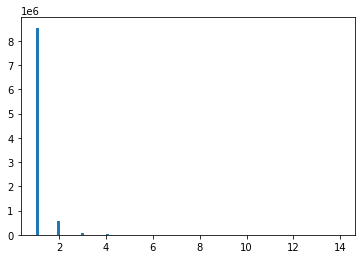

In [51]:
_ = plt.hist(counts, bins=100)

# SQL + Python hybrid

In [56]:
se.table("page_views").show(5)

+--------------+-----------+---------+--------+------------+--------------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|
+--------------+-----------+---------+--------+------------+--------------+
|1fd5f051fba643|        120| 31905835|       1|          RS|             2|
|8557aa9004be3b|        120| 32053104|       1|       VN>44|             2|
|c351b277a358f0|        120| 54013023|       1|       KR>12|             1|
|8205775c5387f9|        120| 44196592|       1|       IN>16|             2|
|9cb0ccd8458371|        120| 65817371|       1|   US>CA>807|             2|
+--------------+-----------+---------+--------+------------+--------------+
only showing top 5 rows



In [57]:
df = se.sql(
"""
select 
    uuid, 
    collect_list(struct(document_id, timestamp, platform, geo_location, traffic_source)) as views
from page_views_sample
group by uuid
""")
df.printSchema()

root
 |-- uuid: string (nullable = true)
 |-- views: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- document_id: string (nullable = true)
 |    |    |-- timestamp: string (nullable = true)
 |    |    |-- platform: string (nullable = true)
 |    |    |-- geo_location: string (nullable = true)
 |    |    |-- traffic_source: string (nullable = true)



In [59]:
%%time
! hdfs dfs -rm -r /platforms_per_user.pickle
from collections import defaultdict

def mapper(x):
    d = defaultdict(int)
    for row in x.views:
        d[row.platform] += 1
    return (x.uuid, d)

df.rdd.map(mapper).saveAsPickleFile("/platforms_per_user.pickle")

Deleted /platforms_per_user.pickle
CPU times: user 29.2 ms, sys: 10.2 ms, total: 39.4 ms
Wall time: 29.8 s


# The same in Python (5x slower)

In [7]:
%%time
! hdfs dfs -rm -r /platforms_per_user2.pickle

def mapper(x):
    d = defaultdict(int)
    for row in x[1]:
        d[row.platform] += 1
    return (x[0], d)

(
    se
    .table("page_views")
    .rdd
    .groupBy(lambda x: x.uuid)
    .map(mapper)
    .saveAsPickleFile("/platforms_per_user2.pickle")
)

rm: `/platforms_per_user2.pickle': No such file or directory
CPU times: user 125 ms, sys: 86.1 ms, total: 211 ms
Wall time: 52min 8s


# Homework 1: Spark EDA

1. Find 10 most visited document_ids in page_views log

In [92]:
page_view_table_name = 'page_views'

In [79]:
se.table(f"{page_view_table_name}")

DataFrame[uuid: string, document_id: string, timestamp: string, platform: string, geo_location: string, traffic_source: string]

In [80]:
df = se.sql(
            f"""
            SELECT document_id, COUNT(*) as freq 
            from {page_view_table_name} 
            GROUP BY document_id 
            ORDER BY freq desc
            """
            )

df.show(10)

+-----------+--------+
|document_id|    freq|
+-----------+--------+
|    1179111|26688981|
|     394689|10454691|
|       2191| 5044391|
|       7054| 4996916|
|      38922| 4930261|
|    1154100| 4610780|
|     357569| 4046253|
|    1827718| 3046274|
|        234| 2359994|
|     467462| 2328065|
+-----------+--------+
only showing top 10 rows



2. Find 10 most visited topic_ids in page_views log (use documents_topics table)

In [81]:
df = se.sql(
            f"""
            SELECT documents_topics.topic_id, COUNT(*) as freq 
            from {page_view_table_name}
            INNER JOIN documents_topics ON {page_view_table_name}.document_id = documents_topics.document_id
            GROUP BY topic_id 
            ORDER BY freq desc
            """
            )

df.show(10)

+--------+---------+
|topic_id|     freq|
+--------+---------+
|      16|226580657|
|     140|175020525|
|      20|171010359|
|     143|153101583|
|     136|137553975|
|     216|109567943|
|       8|105683622|
|     160| 99645579|
|     181| 98421838|
|      97| 90551102|
+--------+---------+
only showing top 10 rows



3. Find out how many users have at least two different traffic_sources in their page_views log

In [82]:
se.table(f"{page_view_table_name}")

DataFrame[uuid: string, document_id: string, timestamp: string, platform: string, geo_location: string, traffic_source: string]

In [93]:
df = se.sql(
            f"""
            WITH traffic_source_counts AS
            (SELECT uuid, COUNT(DISTINCT traffic_source) freq
            from {page_view_table_name} 
            GROUP BY uuid)
            SELECT COUNT(*) from traffic_source_counts where freq >= 2
            """
            )
df.show(10)


+--------+
|count(1)|
+--------+
|93342305|
+--------+



4. Find out the average uuid (user) CTR (number of clicks in all of her display_ids / (number of impressions ... + 10)). Plot the distribution of individual CTRs as a histogram (bins=100).

In [109]:
page_view_table_name = 'page_views'

df_ctr = se.sql(
            f"""
            
            WITH freqs as
            
                (WITH 
                impressions AS 
                (
                SELECT uuid, COUNT(*) as freq from {page_view_table_name} 
                GROUP BY uuid
                ),
                clicks as 
                (
                SELECT uuid, COUNT(*) as freq from events
                GROUP BY uuid
                )            
                SELECT impressions.uuid, impressions.freq impressions, clicks.freq clicks from impressions 
                INNER JOIN clicks ON impressions.uuid = clicks.uuid)
            
            SELECT uuid, freqs.clicks/(freqs.impressions+10) ctr FROM freqs
            ORDER BY ctr DESC
            
            """
            )


In [111]:
df_ctr.write.parquet('/ctr.parquet', mode='overwrite')

In [119]:
df = se.read.parquet("/ctr.parquet")


In [135]:
vals = df.select('ctr').rdd.flatMap(lambda x: x).collect()


(array([3.741100e+04, 2.541720e+05, 5.645290e+05, 8.588840e+05,
        1.049571e+06, 1.207626e+06, 1.394484e+06, 1.330917e+06,
        1.883187e+06, 2.876870e+06, 2.295744e+06, 4.880637e+06,
        1.593890e+05, 9.679900e+04, 1.014640e+05, 9.718200e+04,
        1.125380e+05, 1.060530e+05, 1.074710e+05, 1.114540e+05,
        1.727300e+04, 1.001980e+05, 1.596100e+04, 5.435600e+04,
        1.459000e+04, 1.565000e+03, 1.395600e+04, 1.227400e+04,
        3.436000e+03, 1.036000e+03, 9.774000e+03, 1.217000e+03,
        8.227000e+03, 2.860000e+02, 2.173000e+03, 3.932000e+03,
        6.110000e+02, 1.396000e+03, 5.300000e+02, 3.160000e+02,
        1.242000e+03, 3.140000e+02, 3.900000e+01, 1.203000e+03,
        2.900000e+01, 1.320000e+02, 3.080000e+02, 6.200000e+02,
        5.500000e+01, 1.250000e+02, 2.580000e+02, 2.400000e+01,
        1.200000e+02, 4.700000e+01, 1.800000e+02, 2.600000e+01,
        8.600000e+01, 3.200000e+01, 2.800000e+01, 1.410000e+02,
        6.100000e+01, 4.300000e+01, 1.20

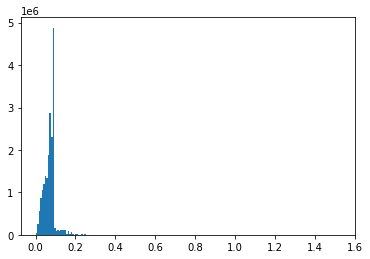

In [140]:
plt.hist(vals, bins=200)

In [125]:
print("Average CTR")
df.select(mean("ctr")).show()

Average CTR
+-------------------+
|           avg(ctr)|
+-------------------+
|0.07105403006660217|
+-------------------+



5. Find out how many page views has an average user before encountering a display_id (use timestamp columns). Plot the distribution of individual values.

In [ ]:
# YOUR CODE HERE